In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import datetime


In [2]:
# All Defined funstions

def trim_all_columns(df):
# Trim whitespace from ends of each value across all series in dataframe    
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)



def clip_outliers(df ,List, std_coeff=3 ):
    for c in List:
        if ( ( df[c].dtypes == 'int64' )  |  ( df[c].dtypes == 'float' ) ):
            L=df[c].mean()-std_coeff*df[c].std()
            U=df[c].mean()+std_coeff*df[c].std()
            df[c]=df[c].clip(L, U) #, inplace= True, axis= 1)
    return df



In [3]:

df_cust=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_customer.csv',sep=';') 
df_accounts=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_accounts.csv',sep=';')

df_checking_acct=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_checking_acct.csv',sep=';')
df_saving_acct=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_savings_acct.csv',sep=';')
df_credit_acct=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_credit_acct.csv',sep=';')

df_transactions=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_transactions.csv',sep=';')
df_checking_tran=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_checking_tran.csv',sep=';')
df_saving_tran=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_savings_tran.csv',sep=';')
df_credit_tran=pd.read_csv(r'D:\0-LHL-Activities\W05\Mini-project-III\Data\twm_credit_tran.csv',sep=';')


df_cust =trim_all_columns( df_cust ) 
df_accounts =trim_all_columns( df_accounts ) 

df_checking_acct =trim_all_columns( df_checking_acct ) 
df_saving_acct   =trim_all_columns( df_saving_acct )
df_credit_acct   =trim_all_columns( df_credit_acct )

df_transactions  =trim_all_columns( df_transactions )
df_checking_tran =trim_all_columns( df_checking_tran )
df_saving_tran   =trim_all_columns( df_saving_tran )
df_credit_tran   =trim_all_columns( df_credit_tran )

df_transactions.tran_date=pd.to_datetime(df_transactions.tran_date)
df_checking_tran.tran_date=pd.to_datetime(df_checking_tran.tran_date)
df_saving_tran.tran_date=pd.to_datetime(df_saving_tran.tran_date)
df_credit_tran.tran_date=pd.to_datetime(df_credit_tran.tran_date)



#df_accounts.head(20)b
#df_accounts.info()
#df_accounts['cust_id'].value_counts()
#df_cust['cust_id'].value_counts()
#df_cust.shape
#df_accounts.shape
df_checking_tran.head()

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,1363481,26,-0.15,-0.15,0.0,58.99,1995-01-29,,,FK
1,1362784,90,-200.00,-200.00,0.0,1380.69,1995-02-07,53313,A,WD
2,1363088,46,0.00,0.00,0.0,128.35,1995-03-26,834,A,IQ
3,1363306,32,-40.32,-40.32,0.0,433.06,1995-01-29,,P,WD
4,1363251,11,-87.88,-87.88,0.0,1919.55,1995-08-02,,P,WD


In [4]:
df_checking_tran['acct_type'] = 'CK'
df_saving_tran['acct_type']   = 'SV'
df_credit_tran['acct_type']   = 'CC'

df_trans_all=df_checking_tran.append([df_saving_tran,df_credit_tran])
df_trans_all.head()
#df_trans_all.info

df_trans_all_1 = df_trans_all.copy()
df_trans_all_1 = df_trans_all_1.drop('acct_type', axis=1)
df_trans_all_1 = df_trans_all_1.drop('cust_id', axis=1)

df_trans_all_2 = df_transactions.copy()
df_trans_all_2 = df_trans_all_2.drop('acct_nbr', axis=1)

#df_trans_all_1.compare(df_trans_all_2)





In [5]:
df_checking_acct.head()


#df_checking_tran.head()

#a=df_checking_tran.groupby('cust_id').agg({'tran_date':np.max})
#print( datetime.datetime(1996, 1, 1)-a)






,cust_id,acct_nbr,minimum_balance,per_check_fee,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,1362548,13625482,3000,0.00,Y,11.11.1986,NaN,6004.34,569.65
1,1362487,13624872,3000,0.00,Y,12.1.1995,NaN,2781.07,1401.21
2,1363017,13630172,3000,0.00,Y,19.3.1994,NaN,2694.91,147.15
3,1362752,13627522,100,0.15,Y,8.1.1994,NaN,487.69,3.76
4,1363282,13632822,100,0.15,Y,5.3.1988,NaN,133.90,84.18


In [6]:
# Add different info from other tables to df_acct_tran

df_acct_tran=df_accounts.copy()

df_acct_tran['years_with_bank'] = 0
df_acct_tran['num_tran'] = 0
df_acct_tran['dp_tran'] = 0
df_acct_tran['wd_tran'] = 0
df_acct_tran['ave_tran_amt'] = 0
df_acct_tran['recency'] = ''



for i in range(len(df_acct_tran.index)):
    Lookfor_cust_id   = df_acct_tran.cust_id[i]
    Lookfor_acct_type = df_acct_tran.acct_type[i]
    #Lookfor_acc_nbr = df_acct_tran.acct_nbr[i]
    
    # Add years_with_bank from df_cust to df_acct_tran
    df_acct_tran.years_with_bank[i] = df_cust[ df_cust.cust_id == Lookfor_cust_id ].years_with_bank
    
    # CK: Add Number of transactions,summation of Positive transactions, summation of Negative transactions
    if Lookfor_acct_type.strip() == 'CK':
        df_acct_tran.num_tran[i] = df_checking_tran.cust_id.loc[(df_checking_tran.cust_id == Lookfor_cust_id)].count()  
        df_acct_tran.dp_tran[i]  = df_checking_tran.tran_amt.loc[(df_checking_tran.cust_id == Lookfor_cust_id) & 
                                                                  (df_checking_tran.tran_amt > 0)].sum()  
        df_acct_tran.wd_tran[i]  =-df_checking_tran.tran_amt.loc[(df_checking_tran.cust_id == Lookfor_cust_id) & 
                                                                  (df_checking_tran.tran_amt < 0)].sum()  
        df_acct_tran.ave_tran_amt[i]= (df_acct_tran.dp_tran[i] + df_acct_tran.wd_tran[i] ) / df_acct_tran.num_tran[i]
        
        df_acct_tran.recency[i]  = (datetime.datetime(1996, 1, 1)-
                                    (df_checking_tran.tran_date.loc[(df_checking_tran.cust_id == Lookfor_cust_id)].max()))/np.timedelta64(1,'D')

    # SV: Add Number of transactions,summation of Positive transactions, summation of Negative transactions    
    if Lookfor_acct_type.strip() == 'SV':
        df_acct_tran.num_tran[i] = df_saving_tran.cust_id.loc[(df_saving_tran.cust_id == Lookfor_cust_id)].count() 
        df_acct_tran.dp_tran[i]  = df_saving_tran.tran_amt.loc[(df_saving_tran.cust_id == Lookfor_cust_id) & 
                                                                (df_saving_tran.tran_amt > 0)].sum()  
        df_acct_tran.wd_tran[i]  =-df_saving_tran.tran_amt.loc[(df_saving_tran.cust_id == Lookfor_cust_id) & 
                                                                (df_saving_tran.tran_amt < 0)].sum()  
        df_acct_tran.ave_tran_amt[i]= (df_acct_tran.dp_tran[i] + df_acct_tran.wd_tran[i] ) / df_acct_tran.num_tran[i]
        df_acct_tran.recency[i]  = (datetime.datetime(1996, 1, 1)-
                                    (df_saving_tran.tran_date.loc[(df_saving_tran.cust_id == Lookfor_cust_id)].max()))/np.timedelta64(1,'D')

    # CC: Add Number of transactions,summation of Positive transactions, summation of Negative transactions    
    if Lookfor_acct_type.strip() == 'CC':
        df_acct_tran.num_tran[i] = df_credit_tran.cust_id.loc[(df_credit_tran.cust_id == Lookfor_cust_id)].count() 
        df_acct_tran.dp_tran[i]  = df_credit_tran.tran_amt.loc[(df_credit_tran.cust_id == Lookfor_cust_id) & 
                                                                (df_credit_tran.tran_amt > 0)].sum()                                                                 
        df_acct_tran.wd_tran[i]  =-df_credit_tran.tran_amt.loc[(df_credit_tran.cust_id == Lookfor_cust_id) & 
                                                                (df_credit_tran.tran_amt < 0)].sum()  
        df_acct_tran.ave_tran_amt[i]= (df_acct_tran.dp_tran[i] + df_acct_tran.wd_tran[i] ) / df_acct_tran.num_tran[i]
        df_acct_tran.recency[i]  = (datetime.datetime(1996, 1, 1)-
                                    (df_credit_tran.tran_date.loc[(df_credit_tran.cust_id == Lookfor_cust_id)].max()))/np.timedelta64(1,'D') 
        
df_acct_tran.head(26)   

,acct_nbr,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance,years_with_bank,num_tran,dp_tran,wd_tran,ave_tran_amt,recency
0,13628063,1362806,SV,Y,10.12.1995,NaN,1430.22,284.58,3,40,1611.39,2757.03,109.210500,1.0
1,4561143213627090,1362709,CC,Y,15.3.1993,NaN,266.34,496.15,4,55,4280.64,4506.70,159.769818,10.0
2,4561143213628360,1362836,CC,Y,18.3.1992,NaN,55.90,1000.00,6,41,1122.86,1937.27,74.637317,8.0
3,13633112,1363311,CK,Y,6.7.1995,NaN,11017.13,968.46,0,99,5978.89,16027.56,222.287374,23.0
4,4561143213633610,1363361,CC,Y,17.6.1994,NaN,849.37,462.28,4,43,5201.82,4802.77,232.664884,1.0
5,4561143213631020,1363102,CC,Y,30.11.1995,NaN,0.00,1000.00,3,17,55.95,1055.95,65.405882,6.0
6,4561143213633270,1363327,CC,Y,2.4.1995,NaN,0.00,3000.00,0,47,1067.48,3947.07,106.692553,6.0
7,13628972,1362897,CK,Y,1.8.1995,NaN,152.12,52.33,2,99,2743.55,2843.34,56.433232,24.0
8,4561143213632370,1363237,CC,N,24.1.1993,30.1.1995,8649.37,0.00,5,1,8735.14,-0.00,8735.140000,336.0
9,13627202,1362720,CK,Y,14.11.1995,NaN,1074.16,216.74,4,99,2632.01,3489.43,61.832727,45.0


In [7]:
# Deleting redundunt columns 
df_acct_tran_clus=df_acct_tran.copy()

mask1=df_acct_tran_clus['acct_type']=='CK' #CK
mask2=df_acct_tran_clus['acct_type']=='CC' #CC
mask3=df_acct_tran_clus['acct_type']=='SV' #SV

df_acct_tran_clus.loc[mask1,'acct_type']=1  #CK
df_acct_tran_clus.loc[mask2,'acct_type']=2  #CC
df_acct_tran_clus.loc[mask3,'acct_type']=3  #SV

mask4=df_acct_tran_clus['account_active']=='Y' #Active
mask5=df_acct_tran_clus['account_active']=='N' #Inactive

df_acct_tran_clus.loc[mask4,'account_active']=1  #Active
df_acct_tran_clus.loc[mask5,'account_active']=0  #Inactive

df_acct_tran_clus['acct_type'     ] = pd.to_numeric(df_acct_tran_clus['acct_type'     ])
df_acct_tran_clus['account_active'] = pd.to_numeric(df_acct_tran_clus['account_active'])
df_acct_tran_clus['recency'       ] = pd.to_numeric(df_acct_tran_clus['recency'       ])

#df_acct_tran_clus.head()
df_acct_tran_clus.describe()

,acct_nbr,cust_id,acct_type,account_active,starting_balance,ending_balance,years_with_bank,num_tran,dp_tran,wd_tran,ave_tran_amt,recency
count,1.409000e+03,1.409000e+03,1409.000000,1409.000000,1409.00000,1409.000000,1409.00000,1409.000000,1409.000000,1409.000000,1397.000000,1397.000000
mean,1.514986e+15,1.362989e+06,1.929737,0.898510,1435.35357,1011.754336,3.84599,55.046132,3630.810646,4063.678772,147.139539,22.477452
std,2.148991e+15,2.940584e+02,0.814484,0.302084,2186.69662,1559.986310,2.68936,33.542608,3812.392741,4354.758379,290.713486,40.630812
min,1.362480e+07,1.362480e+06,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,-0.000000,0.000000,1.000000
25%,1.362852e+07,1.362727e+06,1.000000,1.000000,189.23000,140.000000,2.00000,26.000000,1082.610000,1098.000000,65.690000,1.000000
50%,1.363252e+07,1.362985e+06,2.000000,1.000000,487.69000,553.610000,4.00000,44.000000,2717.510000,3000.000000,100.343333,10.000000
75%,4.561143e+15,1.363251e+06,3.000000,1.000000,2178.79000,1188.570000,6.00000,99.000000,4766.130000,5642.840000,173.139737,29.000000
max,4.561143e+15,1.363495e+06,3.000000,1.000000,27072.38000,22432.780000,9.00000,155.000000,35772.310000,38331.570000,8735.140000,336.000000


In [8]:
# Outlier Detection
df_acct_tran_clus_1=clip_outliers(df_acct_tran_clus,['ending_balance'], std_coeff=3 )
df_acct_tran_clus_1.describe()


,acct_nbr,cust_id,acct_type,account_active,starting_balance,ending_balance,years_with_bank,num_tran,dp_tran,wd_tran,ave_tran_amt,recency
count,1.409000e+03,1.409000e+03,1409.000000,1409.000000,1409.00000,1409.000000,1409.00000,1409.000000,1409.000000,1409.000000,1397.000000,1397.000000
mean,1.514986e+15,1.362989e+06,1.929737,0.898510,1435.35357,950.285845,3.84599,55.046132,3630.810646,4063.678772,147.139539,22.477452
std,2.148991e+15,2.940584e+02,0.814484,0.302084,2186.69662,1184.077416,2.68936,33.542608,3812.392741,4354.758379,290.713486,40.630812
min,1.362480e+07,1.362480e+06,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,-0.000000,0.000000,1.000000
25%,1.362852e+07,1.362727e+06,1.000000,1.000000,189.23000,140.000000,2.00000,26.000000,1082.610000,1098.000000,65.690000,1.000000
50%,1.363252e+07,1.362985e+06,2.000000,1.000000,487.69000,553.610000,4.00000,44.000000,2717.510000,3000.000000,100.343333,10.000000
75%,4.561143e+15,1.363251e+06,3.000000,1.000000,2178.79000,1188.570000,6.00000,99.000000,4766.130000,5642.840000,173.139737,29.000000
max,4.561143e+15,1.363495e+06,3.000000,1.000000,27072.38000,5691.713267,9.00000,155.000000,35772.310000,38331.570000,8735.140000,336.000000


# Clustering

range(1, 6) [665.2820133058357, 441.564712524833, 331.52004901103396, 276.0002419031267, 242.90109286610613]


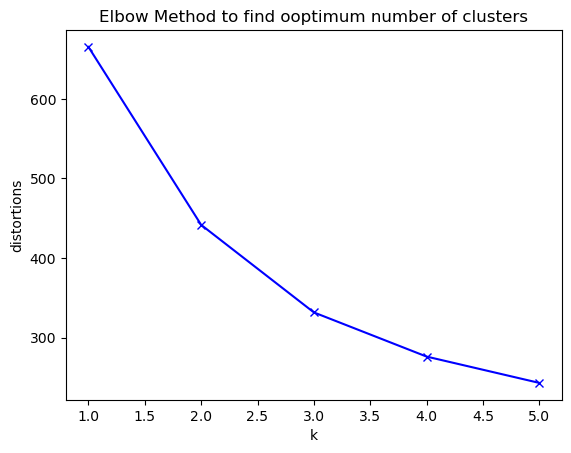

In [10]:
# Clustering



#X=df_acct_tran_clus.drop(['acct_nbr','cust_id','acct_start_date','acct_end_date','starting_balance','dp_tran','wd_tran'],axis=1)
X=df_acct_tran_clus.drop(['acct_nbr','cust_id','acct_start_date','acct_end_date','starting_balance','ave_tran_amt'],axis=1)
X.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)




MMS=MinMaxScaler()
Xnorm=MMS.fit_transform(X)
kmean_model=KMeans(random_state=2023,n_clusters=3,max_iter=300)
kmean_model.fit(Xnorm)


# Elbow Method to find ooptimum number of clusters

distortions=[]
K=range(1,6)

for k in K:
    model=KMeans(n_clusters=k)
    model.fit(Xnorm)
    distortions.append(model.inertia_)

print(K,distortions)
    
plt.plot(K,distortions,'bx-')
plt.xlabel('k')
plt.ylabel('distortions')
plt.title('Elbow Method to find ooptimum number of clusters')
plt.show()

In [11]:
L=kmean_model.labels_
L


array([1, 1, 1, ..., 1, 1, 2])

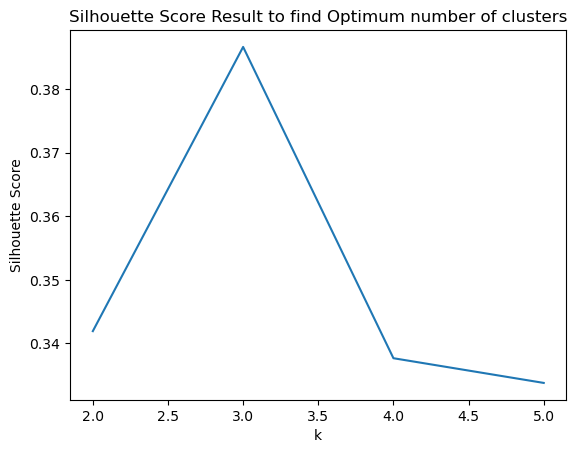

In [12]:
# Silhouette Score Calculations

sil=[]
K=range(2,6)

for k in K:
    model=KMeans(n_clusters=k)
    model.fit(Xnorm)
    L=model.labels_
    sil.append(silhouette_score(Xnorm,L))

plt.plot(K,sil)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Result to find Optimum number of clusters')
plt.show()


# PCA

In [19]:
pca_model=PCA(n_components=3)
pca_model.fit(Xnorm)
X_pca=pca_model.transform(X)
X_pca=pd.DataFrame(X_pca,columns=['PC0','PC1','PC2'])
X_pca.head()

,PC0,PC1,PC2
0,-484.228756,36.267227,-222.735649
1,-931.121446,109.834539,-432.010733
2,-271.240503,-43.195101,-274.389331
3,-2541.814797,162.437335,-1039.546348
4,-1047.658348,142.167462,-475.982403


In [20]:
pca_model.explained_variance_ratio_

array([0.42954265, 0.21338206, 0.17356556])

Text(0, 0.5, '% Cumulative explained variance')

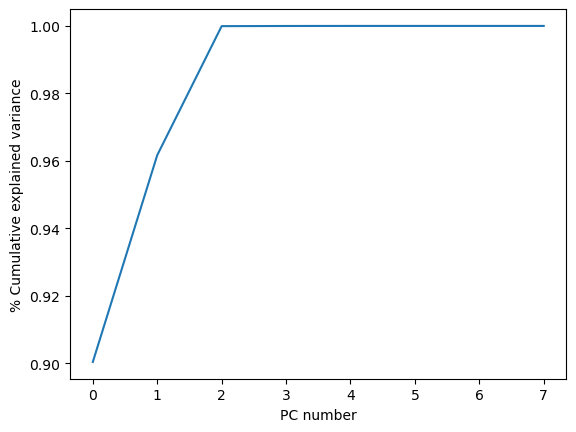

In [21]:
# Create cumulative explained variance graph
# Pretend we'd like to have about 90% explained variance
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_variance)
plt.xlabel('PC number')
plt.ylabel('% Cumulative explained variance')

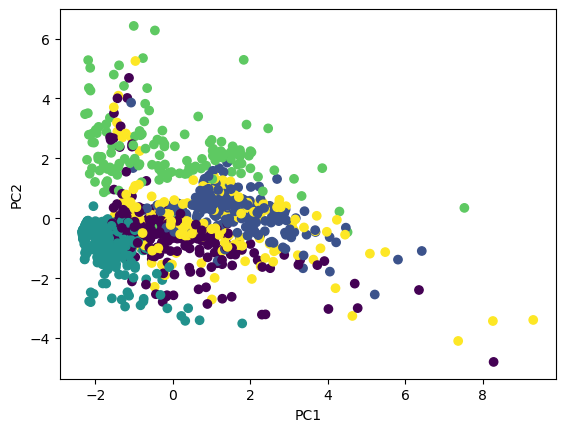

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from numpy import linalg as LA
import pandas as pd
from scipy import stats

#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#In general a good idea is to scale the data
Xscore = stats.zscore(Xnorm)

pca = PCA()
x_new = pca.fit_transform(Xscore)

plt.scatter(x_new[:,0], x_new[:,1],c=L)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()